_Version log: Branch of V9. Trying to apply a 2DFFT insted of a 1DFFT_

In [60]:
import sys, time
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
from matplotlib import pyplot as plt, patches as mplpatches
import scipy.ndimage as spimg
from scipy import fft as spfft, linalg as spla
from PIL import Image #I prefer Pillow to imageio
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $A$ and $\mathcal{F} (Y) = Z$ as,
\begin{equation}
    ||A \times Z - X||_{2} + \alpha ||Z||_{1}.
\end{equation}

In [61]:
def open_compressed_image(file_name, file_type, compression):
    if file_type == ".png" or file_type == ".jpg":
        img = Image.open("data\\" + file_name + file_type) # read image
        img = np.array(img).sum(axis=2) # make image grayscale
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    elif file_type == ".csv":
        with open("data\\" + file_name + file_type, 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
        img = np.loadtxt("data\\" + file_name + file_type, delimiter=delimiter)
        array = spimg.zoom(img, compression, mode= "nearest") # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

def subsample_2d(array, subsampling_percentage = 0.5, subsampling_method = "random"):
    
    array_flat = array.flatten()
    total_points = np.multiply(*array.shape)
    total_rows, total_columns = array.shape
    print(array.shape)

    match subsampling_method: # match case! This can replace endless if elif statements but it is not as versatile.
        case "random":
            reduced_points = round(total_points *subsampling_percentage)
            subsampled_points = np.random.choice(total_points, reduced_points, replace= False)
        case "random_columns":
            reduced_columns = round(total_columns *subsampling_percentage)
            subsampled_columns = np.random.choice(total_columns, reduced_columns, replace= False)
            subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
            subsampled_points = np.array(subsampled_points).flatten()           
        case "random_rows":
            reduced_rows = round(total_rows *subsampling_percentage)
            subsampled_rows = np.random.choice(total_rows, reduced_rows, replace= False)
            subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
            subsampled_points = np.array(subsampled_points).flatten()
        case "regular_columns":
            reduced_columns = round(total_columns *subsampling_percentage)
            subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
            subsampled_points = [subsampled_columns + row_number*total_columns for row_number in range(total_rows)]
            subsampled_points = np.array(subsampled_points).flatten()
        case "regular_rows":
            reduced_rows = round(total_rows *subsampling_percentage)
            subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
            subsampled_points = [column_number + subsampled_rows*total_columns for column_number in range(total_columns)]
            subsampled_points = np.array(subsampled_points).flatten()
        case "regular_grid":
            reduced_columns = round(total_columns *subsampling_percentage**0.5)
            subsampled_columns = np.round(np.linspace(0, total_columns -1, reduced_columns)).astype(int)
            reduced_rows = round(total_rows *subsampling_percentage**0.5)
            subsampled_rows = np.round(np.linspace(0, total_rows -1, reduced_rows)).astype(int)
            subsampled_points = [subsampled_columns + row_number*total_columns for row_number in subsampled_rows]
            subsampled_points = np.array(subsampled_points).flatten()
        case "gaussian" | "normal": # chatgpt mostly did this for me. I'm impressed that it managed to find a sensible value for the std (1/6). I might want to change the while loop though
            reduced_points = round(total_points *subsampling_percentage)
            subsampled_coords = set()
            while len(subsampled_coords) < reduced_points:
                x_coord = int(np.random.normal(total_columns/2, total_columns/3))
                y_coord = int(np.random.normal(total_rows/2, total_rows/3))

                if 0 <= x_coord < total_columns and 0 <= y_coord < total_rows:
                    subsampled_coords.add(x_coord+ y_coord*total_columns)

            subsampled_points = np.array(list(subsampled_coords)) 
        case "hadamard":
            #############IGNORES SUBSAMPLING PERCENTAGE!!!!!!################
            hadamard_size = 2**np.ceil(np.log2(np.max(array.shape))) # Make a hadamard matrix that overfills the image. The size must be a power of 2.
            hadamard_matrix = spla.hadamard(hadamard_size)
            hadamard_matrix = hadamard_matrix[:total_rows, :total_columns] #crop it to the same size as the image
            hadamard_matrix = hadamard_matrix.flatten()
            subsampled_points = np.argwhere(hadamard_matrix == 1).flatten()
        case _: #anything else
            raise ValueError("{0:} is not a valid subsampling method".format(subsampling_method))

    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.
    signal_flat = np.full(total_points, np.nan)
    signal_flat[subsampled_points] = array_flat[subsampled_points]
    signal_sparce = array_flat[subsampled_points]
    signal = np.reshape(signal_flat, array.shape)

    return signal, signal_flat, signal_sparce, subsampled_points

(736, 736)


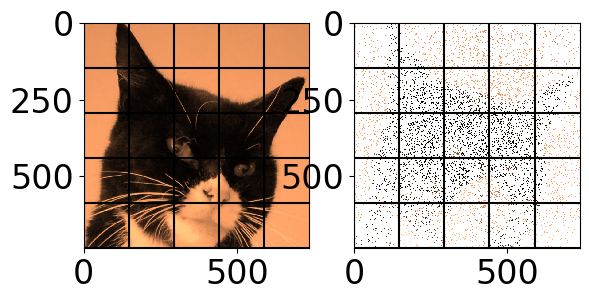

In [62]:
file_name = "alfie"
file_type = ".png"
compression = 1 #fraction of the image to keep (The image is too large to process quickly)
blocks = 25 # splits up the image into more manageable peices. Should be a square number. More blocks may be less accurate?
subsample_percentage = 0.1 #fraction of the image to subsample
subsampling_method= "gaussian" #"random" "random_columns" "random_rows" "regular_grid" "regular_columns" "regular_rows" "hadamard" "gaussian"

# original image
target, img = open_compressed_image(file_name, file_type, compression)
target = np.array(target, dtype= np.float32)
target -= np.mean(target, dtype= np.float32)
total_points = np.multiply(*target.shape)

signal, signal_flat, signal_sparce, random_points_1d = subsample_2d(target, subsampling_method= subsampling_method, subsampling_percentage= subsample_percentage)
random_points_2d = np.argwhere(~np.isnan(signal))

blocks_sqrt = int(np.sqrt(blocks))

fig, axs = plt.subplots(1,2)

axs[0].imshow(target, interpolation= "nearest")
axs[0].vlines(np.linspace(0,1,blocks_sqrt, endpoint= False), 0, 1, color= "k", transform= axs[0].transAxes)
axs[0].hlines(np.linspace(0,1,blocks_sqrt, endpoint= False), 0, 1, color= "k", transform= axs[0].transAxes)
axs[1].imshow(signal, interpolation= "nearest")
axs[1].vlines(np.linspace(0,1,blocks_sqrt, endpoint= False), 0, 1, color= "k", transform= axs[1].transAxes)
axs[1].hlines(np.linspace(0,1,blocks_sqrt, endpoint= False), 0, 1, color= "k", transform= axs[1].transAxes)

plt.show()

In [63]:
def compressed_sensing(samples, regularization_coeffient = 1e-6, silent= True):
    start_time = time.time()

    locations = np.flatnonzero(~np.isnan(samples)) # Where are the known samples located?
    known_samples = np.ravel(samples)[locations] # What are the known samples?
    reduced_points = len(locations) # How many known samples are there?
    total_points = samples.size # How many pixels do we want to reconstruct?
    mean = np.nanmean(samples) # LASSO IGNORES THE MEAN. lasso automatically normalises the samples such that they have a mean of 0. It therefore, cannot recover the zero frequency.
    idx = np.arange(reduced_points)

    dirac_deltas = np.zeros([reduced_points, total_points])
    dirac_deltas[idx, locations] = 1.
    dirac_deltas = np.reshape(dirac_deltas, (reduced_points, samples.shape[0], samples.shape[1]))
    transformation_matrix = spfft.dctn(dirac_deltas, axes= (1,2), norm= "forward", type= 4) #The idea is that do the FT of each samples' dirac delta function to give us the frequency assosciated with that sample. Not convinced that it works the way I think it does. Does work though.
    transformation_matrix = transformation_matrix.reshape(reduced_points, total_points) # 4D matrix squished into 2D. In the first dimention (rows) we have the samples [x1y1,x2y1,x3y1...x1y2...x1y3...] and in the second dimention (columns) we have the frequencies [fx1fy1,fx2fy1,fx3fy1...fx1fy2...fx1fy3...]

    transformation_matrix_time = time.time()
    if not silent: print("It took {0:.3f}s to calculate the transformation matrix".format(transformation_matrix_time -start_time))

    lasso = Lasso(alpha=regularization_coeffient)
    lasso.fit(transformation_matrix, known_samples)
    lasso_time = time.time()
    if not silent: print("It took {0:.3f}s to complete the lasso model".format(lasso_time -transformation_matrix_time))

    result_DCT_flat = lasso.coef_

    result_DCT = result_DCT_flat.reshape(samples.shape)
    result = spfft.idctn(result_DCT, norm= "backward", type= 4) +mean
    return result, result_DCT

In [64]:
block_x = np.linspace(0, signal.shape[1] -1, blocks_sqrt +1, dtype= int)
block_y = np.linspace(0, signal.shape[0] -1, blocks_sqrt +1, dtype= int)

result = np.empty_like(signal)
result_dct = np.empty_like(signal)

for i in tqdm(range(blocks_sqrt)):
    for j in range(blocks_sqrt):

        block = np.s_[block_y[j]:block_y[j+1], block_x[i]:block_x[i+1]]

        result[block], result_dct[block] = compressed_sensing(signal[block], regularization_coeffient= 1e-6, silent= True)


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+04, tolerance: 9.699e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.059e+03, tolerance: 3.899e+03
  model = cd_fast.enet_coordinate_descent(
 20%|██        | 1/5 [02:15<09:01, 135.49s/it]C:\Users\syf836

In [65]:
#result = np.load("data\\result.npy")
#result_dct = np.load("data\\result_dct.npy")
#target = np.load("data\\target.npy")
#target_dct = np.load("data\\target_dct.npy")
#signal = np.load("data\\signal.npy")

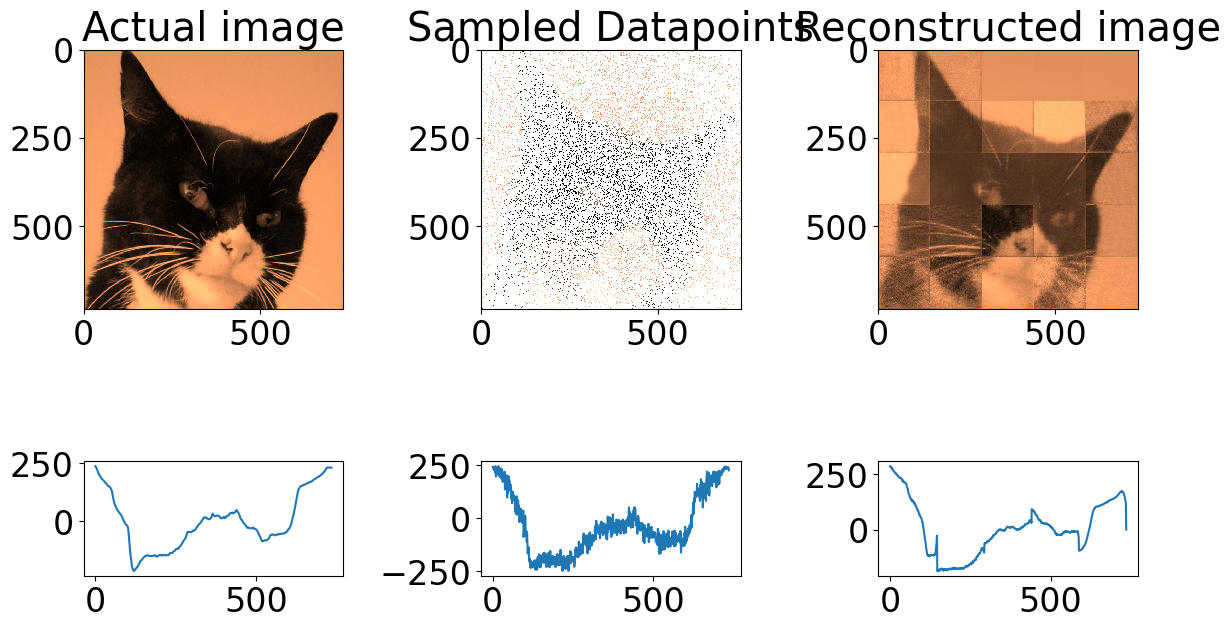

In [66]:
fig, axs = plt.subplots(2,3, figsize= (12,8), height_ratios= [1, 0.2])

axs[0][0].imshow(target, interpolation = "nearest")
axs[0][0].set_title("Actual image")
axs[0][1].imshow(signal, interpolation = "nearest")
axs[0][1].set_title("Sampled Datapoints")
axs[0][2].imshow(result, interpolation = "nearest")
axs[0][2].set_title("Reconstructed image")

axs[1][0].plot(np.nanmean(target, axis= 0))
axs[1][1].plot(np.nanmean(signal, axis= 0))
axs[1][2].plot(np.nanmean(result, axis= 0))

plt.tight_layout()
plt.show()

In [67]:
target_dct = spfft.dctn(target, norm= "forward", type= 4)

is_significant = 1e-10 < np.abs(result_dct)
result_dct[~is_significant] = np.nan

lossy_dct = np.zeros_like(target_dct)
is_significant = np.percentile(np.abs(target_dct), (0.99)*100) < np.abs(target_dct)
lossy_dct[is_significant] = target_dct[is_significant]
lossy = spfft.idctn(lossy_dct, norm= "forward", type= 4)
lossy_dct[~is_significant] = np.nan

p = 0.4

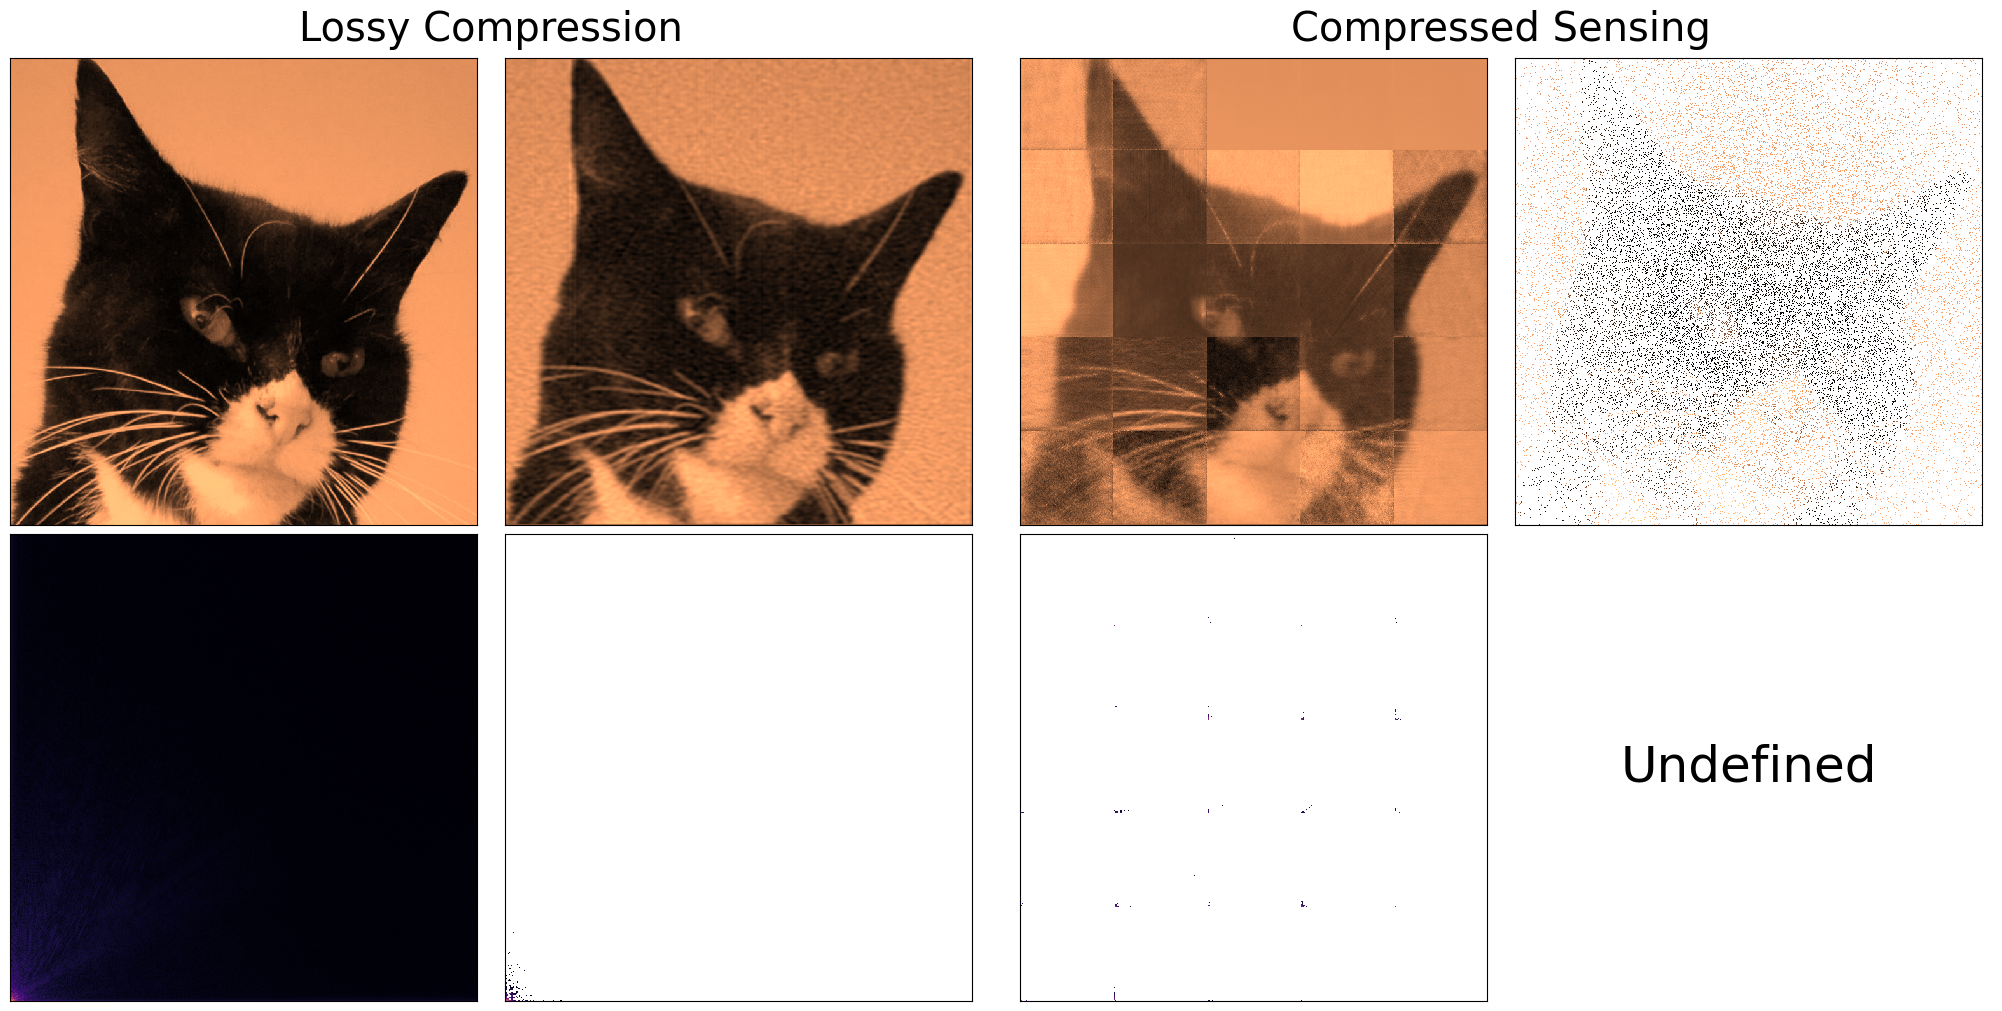

In [68]:
plt.rcParams.update({"font.size": 24, "image.cmap": "copper"})

fig = plt.figure(layout= "constrained", figsize= (20, 10), facecolor='none')
subfigs = fig.subfigures(1, 2)

subfigs[0].suptitle("Lossy Compression")
lossy_compression_axes = subfigs[0].subplots(2, 2, gridspec_kw= {"wspace":0, "hspace":0})
lossy_compression_axes = np.ravel(lossy_compression_axes)

lossy_compression_axes[0].imshow(target, interpolation= "none")
lossy_compression_axes[0].set(xticks= [], yticks= [], facecolor='white')
lossy_compression_axes[2].imshow(np.abs(target_dct)**p, cmap= "magma", origin= "lower")
lossy_compression_axes[2].set(xticks= [], yticks= [], facecolor='white')

lossy_compression_axes[1].imshow(lossy, interpolation= "none")
lossy_compression_axes[1].set(xticks= [], yticks= [], facecolor='white')
lossy_compression_axes[3].imshow(np.abs(lossy_dct)**p, cmap= "magma", origin= "lower")
lossy_compression_axes[3].set(xticks= [], yticks= [], facecolor='white')

#lossy_compression_axes[0].annotate("", xytext=(0.45, 0.5), textcoords='subfigure fraction',
#                                   xy=(0.55, 0.5), xycoords='subfigure fraction',
#                                   arrowprops=dict(facecolor='tab:blue', edgecolor= "none", width= 20, headwidth= 50, headlength= 40))

subfigs[1].suptitle("Compressed Sensing")
compressed_sensing_axes = subfigs[1].subplots(2, 2, gridspec_kw= {"wspace":0, "hspace":0})
compressed_sensing_axes = np.ravel(compressed_sensing_axes)

compressed_sensing_axes[0].imshow(result, interpolation= "none")
compressed_sensing_axes[0].set(xticks= [], yticks= [], facecolor='white')
compressed_sensing_axes[2].imshow(np.abs(result_dct)**p, cmap= "magma", origin= "lower")
compressed_sensing_axes[2].set(xticks= [], yticks= [], facecolor='white')

compressed_sensing_axes[1].imshow(signal, interpolation= "none")
compressed_sensing_axes[1].set(xticks= [], yticks= [], facecolor='white')
compressed_sensing_axes[3].axis("off")
compressed_sensing_axes[3].text(0.5, 0.5, "Undefined", horizontalalignment= "center", verticalalignment= "center", fontsize= 36)
compressed_sensing_axes[3].set(xticks= [], yticks= [], facecolor='white')

#compressed_sensing_axes[0].annotate("", xytext=(0.55, 0.5), textcoords='subfigure fraction',
#                                   xy=(0.45, 0.5), xycoords='subfigure fraction',
#                                   arrowprops=dict(facecolor='tab:blue', edgecolor= "none", width= 20, headwidth= 50, headlength= 40))

fig.savefig("graphs\\alfie_lc_vs_cs2")
plt.show()


In [69]:
#np.save("data\\result", result)
#np.save("data\\result_dct", result_dct)
#np.save("data\\target", target)
#np.save("data\\target_dct", target_dct)
#np.save("data\\signal", signal)

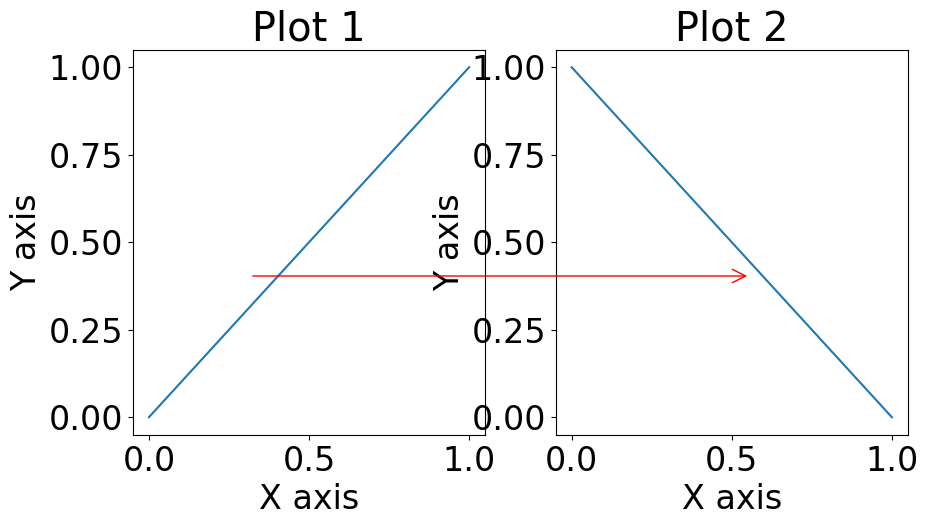

In [70]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot some data on both axes
ax1.plot([0, 1], [0, 1], label='Line 1')
ax2.plot([0, 1], [1, 0], label='Line 2')

# Annotate on the figure level
plt.annotate(
    '', 
    xy=(0.75, 0.5),  # end point in figure coordinates
    xytext=(0.25, 0.5),  # start point in figure coordinates
    xycoords='figure fraction',  # use figure coordinates
    arrowprops=dict(arrowstyle='->', color='red')
)

# Add titles and labels
ax1.set_title('Plot 1')
ax2.set_title('Plot 2')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax2.set_xlabel('X axis')
ax2.set_ylabel('Y axis')

# Show the plot
plt.show()
